Season 12-19:
=====================
0.23 + 0.3*dfc["boy_scaled"] - 0.16*dfc["sup_scaled"] - 0.1*dfc["ominousness"] - 0.028*dfc["batting_team_hype"] + 0.028*dfc["pitching_team_hype"]

Season 20:
=====================
0.23 + 0.3*dfc["boy_scaled"] - 0.16*dfc["sup_scaled"] - 0.1*dfc["ominousness"] - 0.018*dfc["batting_team_hype"] + 0.018*dfc["pitching_team_hype"]

Season 21-24:
=====================
0.23 + 0.3*dfc["boy_scaled"] - 0.16*dfc["sup_scaled"] - 0.1*dfc["ominousness"] - 0.0185*dfc["batting_team_hype"] + 0.0185*dfc["pitching_team_hype"]

boy_scaled is the Batter's Buoyancy, with no vibes, negative multipliers, and negative item attributes,
sup_scaled is the Batter's Suppression, with no vibes, normal multipliers, and normal item attributes,
ominousness is the Stadium's Ominousness, and is not centred.
Hype is Hype.

In [1179]:
import load

df = load.data("fly", season=20)

df["boy_scaled"] = load.player_attribute(
        # These values are mandatory: the dataframe, the player role, and the attribute
        df, 'batter', 'buoyancy',
        # These are all optional, and the default values are as they appear here
        vibes=False, mods="negative", items="negative", broken_items=True
    )

df["boy_overunder"] = load.player_attribute(
        # These values are mandatory: the dataframe, the player role, and the attribute
        df, 'batter', 'buoyancy',
        # These are all optional, and the default values are as they appear here
        vibes=False, mods=True, items="negative", broken_items=True
    )

df["sup_scaled"] = load.player_attribute(
        # These values are mandatory: the dataframe, the player role, and the attribute
        df, 'batter', 'suppression',
        # These are all optional, and the default values are as they appear here
        vibes=False, mods=True, items=True, broken_items=True
    )

    # center=True is the default
df["ominousness"] = load.stadium_attribute(df, 'ominousness', center=False)

In [1180]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [1181]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    #if "OVERPERFORMING" in pm:
        #mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    #if "UNDERPERFORMING" in pm:
        #mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "HIGH_PRESSURE" in pm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    #if "SINKING_SHIP" in ptm:
        #mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["runner_name"]].isna().any():
    # row["runner_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
            mul += 0.2
    if "OVERPERFORMING" in btm:
            mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    #if "TRAVELING" in btm:
        #if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            #mul += 0.05
    #if "TRAVELING" in bm:
        #if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            #mul += 0.05
    #if "GROWTH" in btm:
        # Not Real Until Season 16
        #mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "HIGH_PRESSURE" in bm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.45
    #if "SINKING_SHIP" in btm:
        #mul += (14 - row["batting_team_roster_size"]) * 0.01
    #if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        #mul += 0.5
    #if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        #mul += 1.0
        #attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    #if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        #mul += 0.80
        #attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    #if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
       # mul += 2
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["runner_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul, attrs


In [1182]:
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")

In [1183]:
df = df.copy()

In [1184]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["CLUTTERED","SLOW_BUILD", 'UNDEFINED', "TRAVELING", "EARLBIRDS", "OVERPERFORMING", "UNDERPERFORMING"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]


#Inhabited players aren't being grabbed correctly, causing us to use attributes from the wrong ghost.
#Cluttered isn't being accounted for in our formulas
#Undefined isn't being account for in our formulas
#Earlbirds did not trigger Overperforming on S20 D1, and for whatever reason we have not captured Overperforming being active on D2 onwards
#In Season 20 (Unclear if this occurs in other seasons) both Over and Underperforming apply incorrectly to Buoyancy in the sim's formula, specifically they don't apply as a negative as still work as normal (i.e. Underperforming lowers Buoyancy by 20%)
#Slow Build is [SHELLED]


for include_mod in []:
    dfc = dfc[dfc["batter_mods"].astype(str).str.contains(include_mod)]
for exclude_event in []:
    dfc = dfc[~dfc["event_type"].astype(str).str.contains(exclude_event)]

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

len(dfc)

11506

In [1185]:
X = dfc[
    [
        "roll",
        "passed",
        "boy_scaled",
        "sup_scaled",
        "ominousness",
        "batting_team_hype",
        "pitching_team_hype",

    ]
].copy()
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.23
pins = [ (0.3, "boy_scaled"), 
(-0.16, "sup_scaled"),
(-0.1, "ominousness"),
(-0.0185, "batting_team_hype"),
(0.0185, "pitching_team_hype")
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[7941    5]
 [   0 3560]]
5 outliers
0.9995654441161134
0.23


[(1.0, 'roll')]

In [1186]:
dfc["threshold"] = 0.23 + 0.3*dfc["boy_scaled"] - 0.16*dfc["sup_scaled"] - 0.1*dfc["ominousness"] - 0.0185*dfc["batting_team_hype"] + 0.0185*dfc["pitching_team_hype"]



#For Over/Underperforming Tests
dfc["threshold_overunder"] = 0.23 + 0.3*dfc["boy_overunder"] - 0.16*dfc["sup_scaled"] - 0.1*dfc["ominousness"] - 0.0185*dfc["batting_team_hype"] + 0.0185*dfc["pitching_team_hype"]

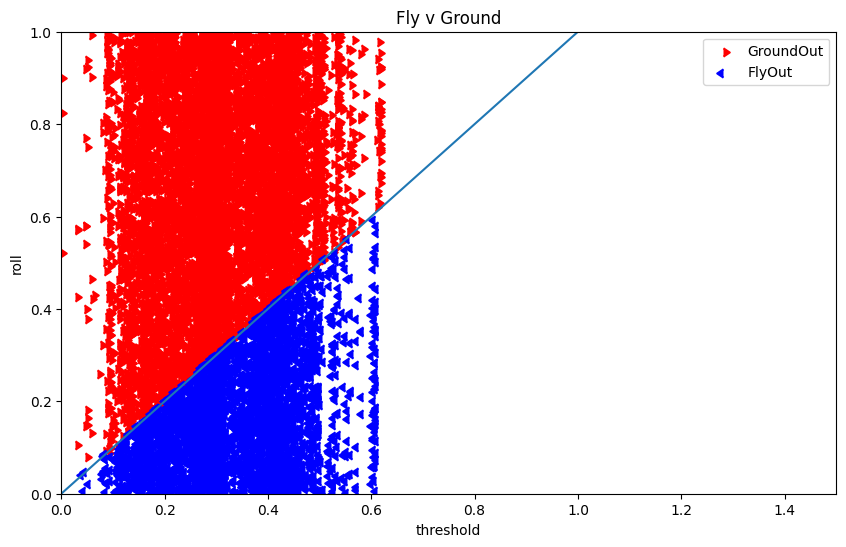

In [1187]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="GroundOut", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="FlyOut", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Fly v Ground")
ax.set_xlim([0.0, 1.5])
ax.set_ylim([0.0, 1])
ax.legend()

,offset,event_type,roll,threshold,batter_name,pitcher_name,batter_mods,batting_team_mods,roll,threshold_overunder,ominousness,day,game_id,play_count
9837,-0.005038,GroundOut,0.360307,0.365345,Lachlan Shelton,Yummy Elliott,SLOW_BUILD,HIGH_PRESSURE;MODERATION;H20,0.360307,0.402182,0.439179,67,3e6575a9-427f-40d9-b097-c84f50a06d25,276
11872,-0.004790,GroundOut,0.271723,0.276513,Cedric Spliff,Winnie Hess,FLINCH;SLOW_BUILD;REPEATING,HIGH_PRESSURE;LATE_TO_PARTY;MODERATION;H20,0.271723,0.293337,0.441699,107,141485eb-aed0-4df8-b17f-7fae6dddc117,207
10994,-0.003535,GroundOut,0.228688,0.232224,Cedric Spliff,Fitzgerald Wanderlust,FLINCH;SLOW_BUILD;REPEATING,HIGH_PRESSURE;LATE_TO_PARTY;MODERATION;H20,0.228688,0.253155,0.914906,102,1d365cdc-7213-4e2b-bf27-23768f8d85e3,308
9987,-0.001712,GroundOut,0.381515,0.383227,Lachlan Shelton,Michelle Sportsman,SLOW_BUILD,HIGH_PRESSURE;MODERATION;H20,0.381515,0.383227,0.439179,68,d8b0f272-5162-4417-9e71-83c47463b641,28
10082,-0.000585,GroundOut,0.379514,0.380099,Lachlan Shelton,Michelle Sportsman,SLOW_BUILD,HIGH_PRESSURE;MODERATION;H20,0.379514,0.386386,0.439179,68,d8b0f272-5162-4417-9e71-83c47463b641,91


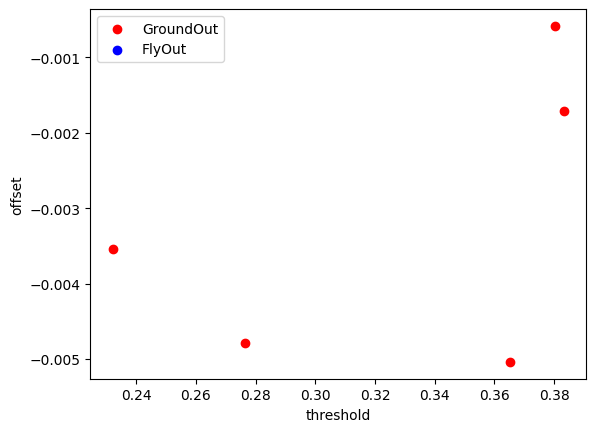

In [1191]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["threshold"] < 0.86]


fig, ax = plt.subplots(1)
x_val = "threshold"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="GroundOut")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="FlyOut")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold",
       "batter_name", "pitcher_name", "batter_mods", "batting_team_mods", "roll", "threshold_overunder", "ominousness",
       "day",  "game_id", "play_count"]].sort_values('offset')


In [1178]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.5934194634509593
0.0797583331728677
